In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense

In [2]:
class StockEnv:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.state_size = data.shape[1] + 3  # stock data + balance + net_worth + stock_owned
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.current_step = 0
        self.stock_owned = 0
        return self._get_observation()

    def _get_observation(self):
        obs = np.hstack((self.data.iloc[self.current_step].values, [self.balance, self.net_worth, self.stock_owned]))
        return obs.astype(np.float32)

    def step(self, action):
        if self.current_step >= len(self.data) - 1:  
            return self._get_observation(), 0, True  # Prevent index error
        
        current_price = self.data.iloc[self.current_step]['Close']
        prev_net_worth = self.net_worth

        if action == 0:  # Buy
            if current_price <= self.balance:
                self.stock_owned += 1
                self.balance -= current_price
        elif action == 1:  # Sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.balance += current_price

        # Update net worth
        self.net_worth = self.balance + self.stock_owned * current_price

        # Move to the next step
        self.current_step += 1

        # Reward based on net worth change
        reward = (self.net_worth - prev_net_worth) / prev_net_worth

        # Check if done
        done = (self.current_step >= len(self.data) - 1)

        return self._get_observation(), reward, done

class ActorCritic:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.learning_rate = 0.001

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        state_input = Input(shape=(self.state_size,))
        dense1 = Dense(32, activation='relu')(state_input)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(self.action_size, activation='softmax')(dense2)

        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def build_critic(self):
        state_input = Input(shape=(self.state_size,))
        dense1 = Dense(32, activation='relu')(state_input)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(1, activation='linear')(dense2)

        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def train(self, state, action, reward, next_state, done):
        target = np.zeros((1, 1))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.gamma * next_value - value
            target[0][0] = reward + self.gamma * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

    def act(self, state):
        probabilities = self.actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=probabilities)
        return action

def test_model(env, actor_critic, stock):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size]).astype(np.float32)
    done = False
    total_reward = 0
    total_rewards = []

    while not done:
        action = actor_critic.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, env.state_size]).astype(np.float32)
        state = next_state
        total_reward += reward
        total_rewards.append(total_reward)

    current_price = env.data.iloc[-1]['Close']
    profit = env.balance + (env.stock_owned * current_price) - env.initial_balance

    plt.plot(total_rewards)
    plt.title(f"{stock}\nTotal Profit: {profit:.2f}")
    plt.xlabel('Days')
    plt.ylabel('Total Rewards')
    plt.show()

    return total_reward, profit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

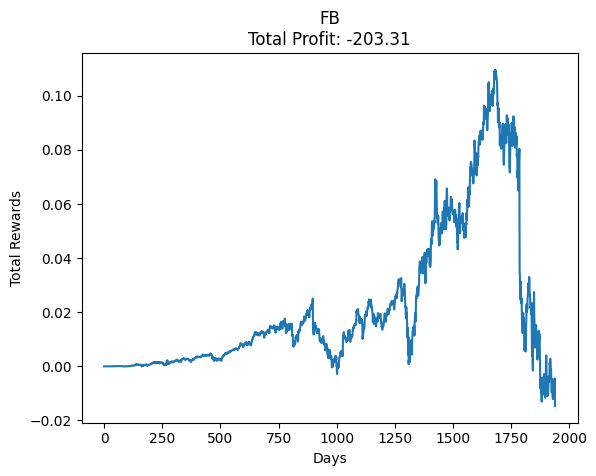

Stock: FB, Total Reward: -0.0146, Profit: -203.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

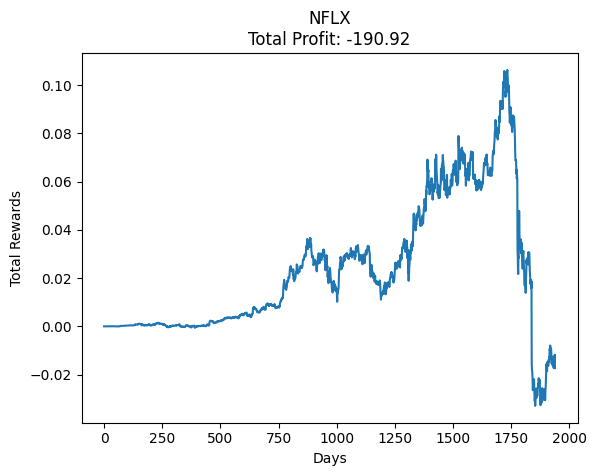

Stock: NFLX, Total Reward: -0.0173, Profit: -190.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/st

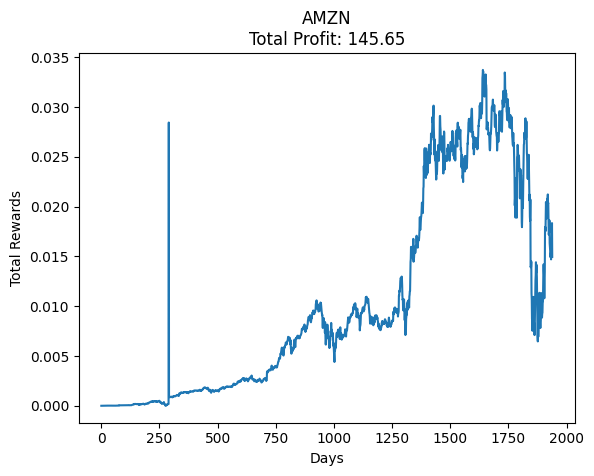

Stock: AMZN, Total Reward: 0.0150, Profit: 145.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

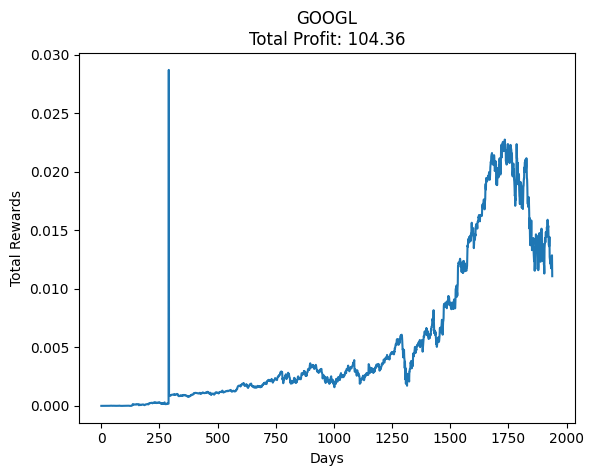

Stock: GOOGL, Total Reward: 0.0111, Profit: 104.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

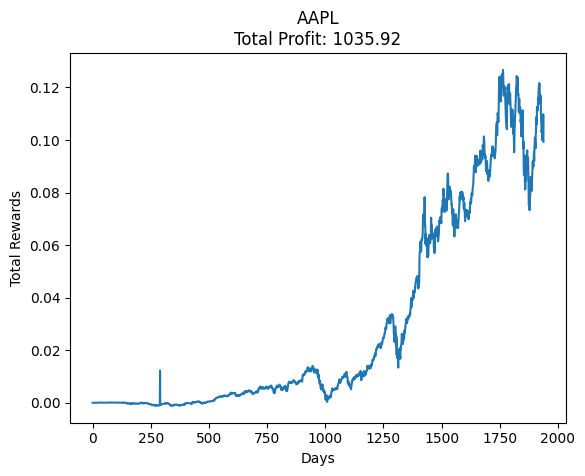

Stock: AAPL, Total Reward: 0.0993, Profit: 1035.92


In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/new-dataset-csv/portfolio-optimisation/new_dataset.csv')
groups = list(set(df['Symbol']))

grouped_df = df.groupby('Symbol')

for i in range(min(5, len(groups))):  # Ensure it does not exceed available stocks
    data = grouped_df.get_group(groups[i])
    data = data[['Open', 'High', 'Low', 'Close']]
    
    # Scale data
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    env = StockEnv(data)
    state_size = env.state_size
    action_size = 3  # Buy, Sell, Hold

    actor_critic = ActorCritic(state_size=state_size, action_size=action_size)

    # Load pre-trained models with error handling
    try:
        actor_critic.actor = load_model('/kaggle/input/new-dataset-csv/portfolio-optimisation/actor400.h5')
        actor_critic.critic = load_model('/kaggle/input/new-dataset-csv/portfolio-optimisation/critic400.h5')
    except Exception as e:
        print(f"Error loading models: {e}")
        continue  # Skip this stock if models fail to load

    total_reward, profit = test_model(env=env, actor_critic=actor_critic, stock=groups[i])
    print(f"Stock: {groups[i]}, Total Reward: {total_reward:.4f}, Profit: {profit:.2f}")